In [141]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from scipy import random
from scipy.spatial.distance import cdist
from scipy.linalg import svd

# K-Multiple-Means

## 1 Dataset

### 1.1 Two Moons

In [14]:
X, y = make_moons(n_samples=200, noise=0.10, random_state=1337)

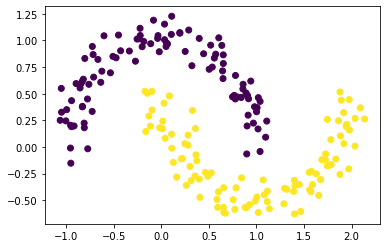

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y);

## 2 Algorithm

### 2.1 General Algorithm

<img src='algorithm.PNG'>

### 2.2 Implementation

In [487]:
# Set initial parameters
k = 2                      # Cluster number
kt = 5                     # Number of neighbor prototypes
m_init = 'kmeans'          # m initialization; kmeans or random

# Set derived parameters
n = len(X)                 # Number of data points
m = int((n*k)**0.5)        # Number of subclusters/prototypes

# Initialization of matrix A
if m_init == 'kmeans':
    A = KMeans(m).fit(X).cluster_centers_
else:
    A = X[random.choice(range(len(X)), size=m, replace=False)]

# Get distance to prototype matrix
d_ij = cdist(X, A)**2

#### Get $\gamma$ and $S$

**Parameter $\gamma$**

\begin{equation}
\gamma = \frac{1}{n} \sum_{i=1}^n \left( \frac{\tilde{k}}{2} d^{th}_{i, \tilde{k}+1} - \frac{1}{2} \sum_{j=1}^{\tilde{k}}d_{ij}^{th}\right)
\end{equation}

**Matrix $S$**

\begin{equation}
s_{i\tilde{j}} = \frac{d_{i, \tilde{k} + 1}^{th} - d_{i\tilde{j}}^{th}}{\tilde{k}d^{th}_{i, \tilde{k}+1} - \sum_{j=1}^{\tilde{k}} d_{i\tilde{j}}^{th}}
\end{equation}

In [575]:
def get_S(d_ij, kt):
    """Return S and gamma given distance to prototype matrix and kt setting"""
    # Get numerator & denominator value of S, and gamma.
    d_th = (np.sort(d_ij, axis=1))
    denom = (kt*d_th[:, kt] - d_th[:, :kt].sum(axis=1))
    gamma = (1 / (2*n) * denom).sum()
    nume = (d_th[:, kt].reshape(n, -1) - d_th[:, :kt])
    S = nume / denom.reshape(n, -1)
    
    return S, gamma

In [585]:
# Get numerator & denominator value of S, and gamma.
d_th = (np.sort(d_ij, axis=1))
denom = (kt*d_th[:, kt] - d_th[:, :kt].sum(axis=1))
gamma = (1 / (2*n) * denom).sum()
nume = (d_th[:, kt].reshape(n, -1) - d_th[:, :kt])
S = nume / denom.reshape(n, -1)
S = np.pad(S, ((0, 0), (0, 15)))

#### Update $F$

$$
F = \begin{bmatrix} U \\ V \end{bmatrix}
$$

$U$ and $V$ are the left and right singular vectors of $D_U^{-\frac{1}{2}} S D_V^{-\frac{1}{2}}$

Where 

$$
P = \begin{bmatrix}  & S \\ S^T & \end{bmatrix}
$$

and 

$$
d_{ii} = \sum_j p_{ij}
$$

and

$$
D = \begin{bmatrix} D_U & \\  & D_V \end{bmatrix}
$$

In [586]:
# Matrix P
P = np.block([[np.zeros((S.shape[0], S.shape[0])), S],
              [S.T, np.zeros((S.shape[1], S.shape[1]))]])

# Matrix D
D = np.diag(P.sum(axis=1)**-0.5)
D[D == np.inf] = 1/np.finfo(float).eps
D_U = D[:n, :n]
D_V = D[-m:, -m:]
# D_V = D[-kt:, -kt:]

# Perform SVD on the multiplied matrix
U, s, Vh = svd(D_U @ S @ D_V, full_matrices=False)

# # Get F
F = np.block([[U[:, -2:]], [Vh.T[:, -2:]]]) / 2**0.5

<ipython-input-586-2beeab1f339d>:6: RuntimeWarning: divide by zero encountered in power
  D = np.diag(P.sum(axis=1)**-0.5)


#### Update S

$$
v_{ij} = \left \Vert \frac{f_i}{\sqrt{d_i}} - \frac{f_{(n+j)}}{\sqrt{d_{(n+j)}}} \right \Vert _2^2
$$

In [615]:
U.shape

(200, 20)

In [609]:
F

array([[-4.93632289e-02, -4.07236645e-02],
       [ 6.56892111e-02, -1.29435329e-02],
       [ 5.22438689e-02, -6.50769017e-02],
       [-5.49251307e-02, -6.33912566e-02],
       [-6.94322627e-02,  5.54280328e-02],
       [ 3.67463169e-03,  6.89025475e-01],
       [ 6.84415609e-01,  5.71391714e-03],
       [-9.76860799e-03,  1.72531831e-02],
       [-2.06678594e-02,  2.31730177e-03],
       [-1.79684036e-02, -1.46331089e-03],
       [-1.16766551e-02,  8.75131900e-03],
       [-4.85972294e-03, -1.61601495e-03],
       [ 5.70282726e-04,  1.20919123e-02],
       [ 3.50235341e-03, -1.38112447e-02],
       [-4.05094609e-03,  4.25678071e-03],
       [ 2.15219768e-03, -1.75749931e-02],
       [ 7.14802772e-03, -1.00882198e-02],
       [-2.57739965e-03, -6.93202560e-03],
       [-1.72162897e-04,  2.26838016e-04],
       [-1.35531556e-02, -1.02286662e-03],
       [-1.70431428e-02,  4.09155587e-03],
       [-9.76897877e-03, -1.87812151e-04],
       [ 2.47153009e-03, -7.00289444e-03],
       [-2.

In [608]:
f2

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.05367121e-08],
       [1.05367121e-08, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00]])

In [605]:
f2

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.05367121e-08],
       [1.05367121e-08, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00]])

In [604]:
f1

array([[-4.93632289e-02, -4.07236645e-02],
       [ 6.56892111e-02, -1.29435329e-02],
       [ 5.22438689e-02, -6.50769017e-02],
       [-5.49251307e-02, -6.33912566e-02],
       [-6.94322627e-02,  5.54280328e-02],
       [ 3.67463169e-03,  6.89025475e-01],
       [ 6.84415609e-01,  5.71391714e-03],
       [-9.76860799e-03,  1.72531831e-02],
       [-2.06678594e-02,  2.31730177e-03],
       [-1.79684036e-02, -1.46331089e-03],
       [-1.16766551e-02,  8.75131900e-03],
       [-4.85972294e-03, -1.61601495e-03],
       [ 5.70282726e-04,  1.20919123e-02],
       [ 3.50235341e-03, -1.38112447e-02],
       [-4.05094609e-03,  4.25678071e-03],
       [ 2.15219768e-03, -1.75749931e-02],
       [ 7.14802772e-03, -1.00882198e-02],
       [-2.57739965e-03, -6.93202560e-03],
       [-1.72162897e-04,  2.26838016e-04],
       [-1.35531556e-02, -1.02286662e-03],
       [-1.70431428e-02,  4.09155587e-03],
       [-9.76897877e-03, -1.87812151e-04],
       [ 2.47153009e-03, -7.00289444e-03],
       [-2.

In [587]:
f1 = F[:n] / (D.sum(1)[:n]**0.5).reshape(n, -1)
f2 = F[n:] / (D.sum(1)[n:]**0.5).reshape(m, -1)
# f2 = F[n:] / (D.sum(1)[n:]**0.5).reshape(kt, -1)
v = cdist(f1, f2)**2

$$
\tilde{d}_{ij} = d_{ij}^x + \lambda v_{ij}
$$

In [623]:
f2

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.05367121e-08],
       [1.05367121e-08, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00]])

In [597]:
lambd = 200*gamma
# d_tild = d_ij + lambd*np.pad(v, ((0, 0), (0, 15)))
d_tild = d_ij + lambd*v

In [601]:
d_ij

array([[2.31563572, 0.35743856, 1.42304539, ..., 2.28674856, 0.61208338,
        1.06974216],
       [2.39198417, 1.08798642, 0.10459508, ..., 1.47734392, 0.26962947,
        0.4392554 ],
       [6.66173848, 0.60622802, 1.99712519, ..., 0.07302925, 0.4478743 ,
        3.12030835],
       ...,
       [8.43446721, 1.78569613, 2.39255767, ..., 0.09141561, 1.09353863,
        4.11395304],
       [0.11542426, 4.17858667, 2.74833093, ..., 7.77354324, 3.88938617,
        1.15851145],
       [0.80005447, 3.13474006, 0.43625359, ..., 4.33040757, 1.86976788,
        0.11936969]])

In [603]:
v.shape

(200, 20)

In [600]:
d_tild

array([[3.19975464, 1.24155749, 2.30716432, ..., 3.17086748, 1.4962023 ,
        1.95386109],
       [3.35975404, 2.05575629, 1.07236495, ..., 2.44511379, 1.23739933,
        1.40702527],
       [8.16531885, 2.10980839, 3.50070556, ..., 1.57660962, 1.95145467,
        4.62388872],
       ...,
       [8.45776304, 1.80899197, 2.41585351, ..., 0.11471145, 1.11683447,
        4.13724888],
       [0.11842948, 4.18159188, 2.75133614, ..., 7.77654845, 3.89239138,
        1.16151666],
       [0.85506335, 3.18974894, 0.49126247, ..., 4.38541645, 1.92477676,
        0.17437857]])

In [598]:
get_S(d_tild, 5)[0][0, :]

array([0.31320113, 0.2639244 , 0.1846274 , 0.14844387, 0.08980319])

In [599]:
get_S(d_ij, 5)[0][0, :]

array([0.31320113, 0.2639244 , 0.1846274 , 0.14844387, 0.08980319])

In [556]:
S[0, :]

array([0.31320113, 0.2639244 , 0.1846274 , 0.14844387, 0.08980319])